In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde, linregress
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (30., 30.)
#%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [4]:
era_march = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march.p', 'rb'))
era_oct = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_oct.p', 'rb'))
era_all = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2000-2014_18UTC_front.p', 'rb'))
#era_all = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2000-2014.p', 'rb'))

In [7]:
def get_col(var):
    vdic = {}
    vdic['low'] = []
    vdic['high'] = []
    vdic['mean'] = []
    for v in var:
        
        vdic['low'].append(v[16])
        vdic['high'].append(v[9])
        vdic['mean'].append(np.array(v).mean())        
    return vdic

In [8]:
def get_q(var):
    vdic = {}
    vdic['low'] = []
    for v in var:
        
        vdic['low'].append(np.array(v[10:19]).sum())
     
    return vdic

In [9]:
np.median(era_all['q_col'])

0.005772334

In [10]:
np.median(era_all['q925'])

0.01542806951329112

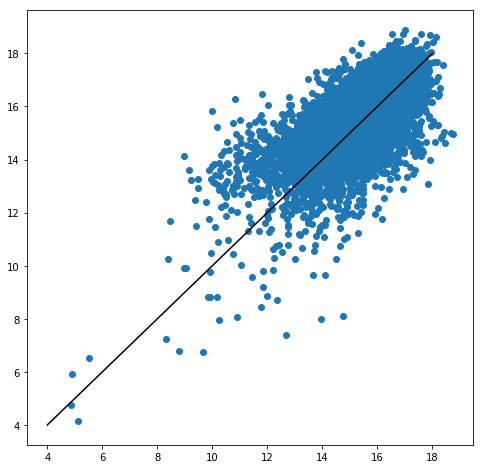

In [11]:
plt.figure(figsize=(8,8))
plt.scatter(np.array(era_all['q925_s'])*1000,np.array(era_all['q925'])*1000)
plt.plot(np.arange(4,19), np.arange(4,19), 'k')

In [12]:
diff = np.array(era_all['q925_s'])*1000-np.array(era_all['q925'])*1000
print(np.sum(diff>0))
print(np.sum(diff<0))

9454
9419


In [188]:
level = era_march.pop('level')
level = era_oct.pop('level')
level = era_all.pop('level')

In [189]:
level[0:19]

[200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 825,
 850,
 875,
 900,
 925,
 950,
 975]

In [190]:
for k in era_march.keys():
    era_march[k] = era_march[k][0:1841]

In [191]:
for k in era_oct.keys():
    era_oct[k] = era_oct[k][0:2096]

In [192]:
np.array(era_oct['CAPE']).mean()

1063.4757279858334

In [193]:
np.array(era_march['CAPE']).mean()

1237.0779014713798

In [194]:
era_all_qsum = get_q(era_all['q_col'])
era_all['q_col_sum'] = era_all_qsum['low']
era_all_qsum_storm = get_q(era_all['q_col_s'])
era_all['q_col_sum_s'] = era_all_qsum_storm['low']

In [195]:
era_new = era_all.copy()
octt = era_all.copy()
marchh = era_all.copy()

In [196]:
for k in era_all.keys():
    print(k)
#     if k == 'dates':
#         continue
    varlist = []
    varo = []
    varm = []
    for ids, ise in enumerate(era_all[k]):
        if (era_all['dates'][ids].month <=6) | (era_all['dates'][ids].month >=9):
            varlist.append(ise)
        if era_all['dates'][ids].month == 3:
            varm.append(ise)
        if era_all['dates'][ids].month == 10:
            varo.append(ise)
    era_new[k] = np.array(varlist)          
    octt[k] = np.array(varo)
    marchh[k] = np.array(varm)

area70
CAPE_s
q925_s
q_col_sum_s
tmin
lat
q_col_s
u_col
q_col_sum
u925
q700_s
v_col_s
t10
dates
u_col_s
CAPE
u925_s
q700
lon
r_col_s
u650_s
v_col
tmean
area
u650
tcwv_s
q925
r_col
tcwv
q_col


In [197]:
qmsort = np.argsort(marchh['q925'])
qm = marchh['q925'][qmsort]

In [198]:
qesort = np.argsort(np.array(era_march['q925']))
qe = np.array(era_march['q925'])[qesort]

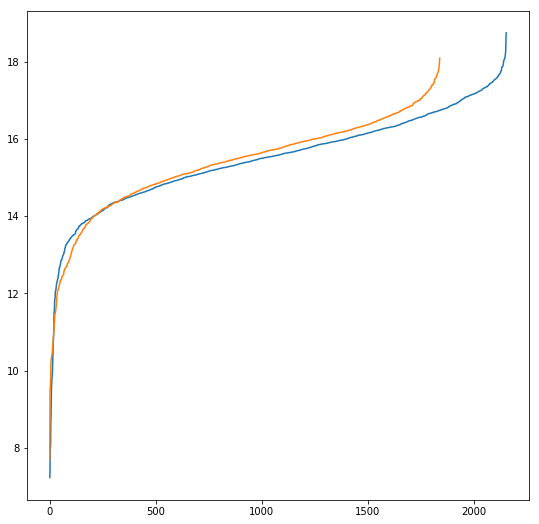

In [199]:
f=plt.figure(figsize=(9,9))
ax = f.add_subplot(111)
plt.plot(qm*1000)
plt.plot(qe*1000)

In [200]:
def sort_vars(dic):
    q925 = np.array(dic['q_col_sum'])
    q925s = np.array(dic['q_col_sum_s'])
    
    udic = get_col(dic['u_col'])
    vdic = get_col(dic['v_col'])
    
    ushear = (np.array(udic['high'])-np.array(udic['low']))
    vshear = (np.array(vdic['high'])-np.array(vdic['low']))
    shearss = u_met.u_v_to_ws_wd(ushear, vshear)
    
    shears = shearss[0]
    #shears = np.array(dic['u650']) - np.array(dic['u925']) #shearss[0]
    q925 = q925 #(q925s-
    sort = np.argsort(q925)
    q = q925[sort]*1000
    shear = shears[sort]
    tmin = np.array(dic['tmean'])[sort]
    linsp = np.linspace(0,len(q)-1,10)
    
    inds = np.round(linsp).astype(int)
    #ipdb.set_trace()
    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    #plt.ylim(8,18)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):  #
        #ipdb.set_trace()
        qmean.append(np.median(q[start:end]))
        corr.append(stats.pearsonr(shear[start:end],tmin[start:end])[0])    
        qcorr.append(stats.pearsonr(shear[start:end],q[start:end])[0])  

#         ttslope, intercept, r, p, std_err = linregress(shear[start:end],tmin[start:end])
#         ccslope, intercept, r, p, std_err = linregress(shear[start:end],q[start:end])
#         corr.append(ttslope)    
#         qcorr.append(ccslope)  
    return qmean, corr, qcorr

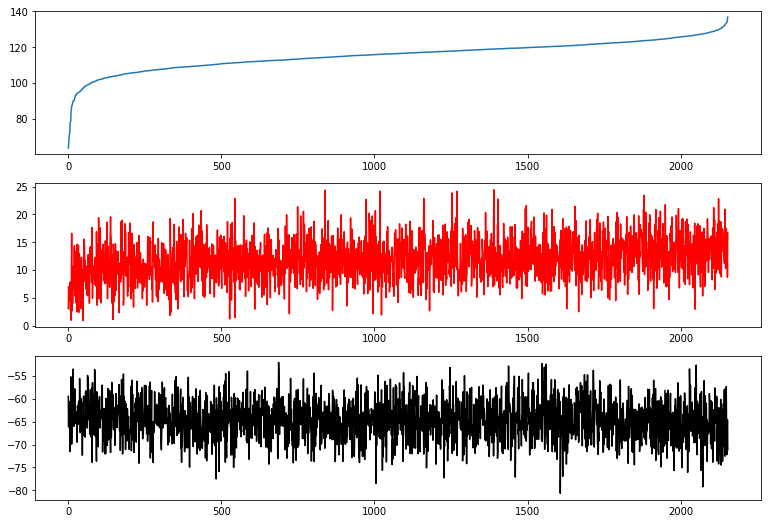

In [201]:
qmean_march, corr_march, qcorr_march = sort_vars(marchh)

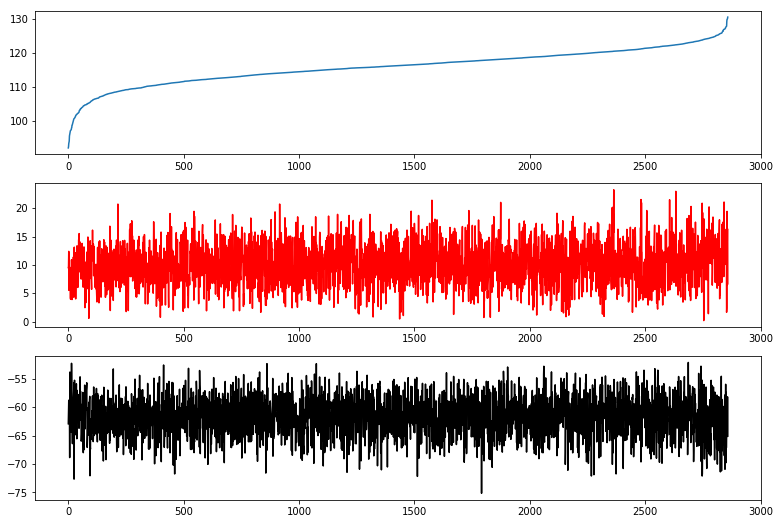

In [202]:
qmean_oct, corr_oct, qcorr_oct = sort_vars(octt)

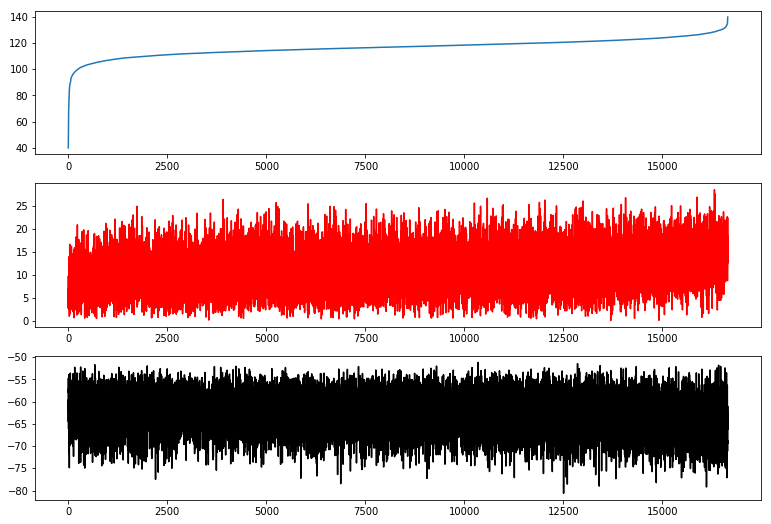

In [203]:
qmean_all, corr_all, qcorr_all = sort_vars(era_new)

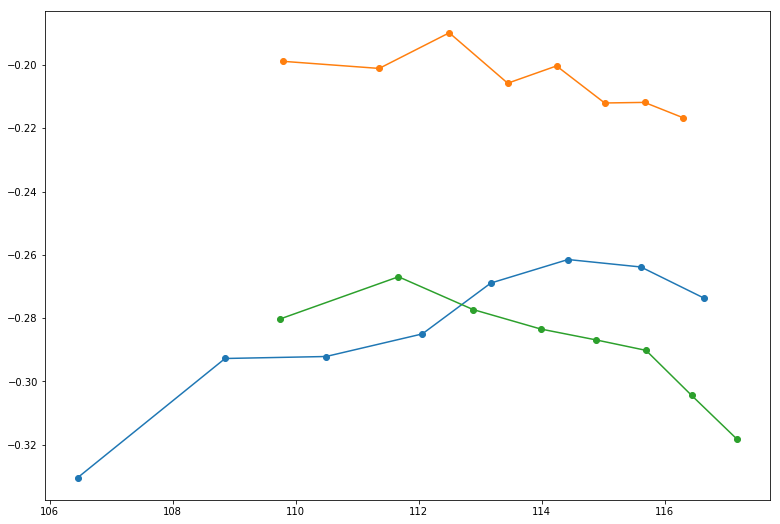

In [204]:
plt.figure(figsize=(13,9))
plt.plot(np.array(qmean_march),corr_march, '-o')
plt.plot(np.array(qmean_oct),corr_oct, '-o')
plt.plot(np.array(qmean_all),corr_all, '-o')

In [206]:
def sort_vars(dic):
    q925 = np.array(dic['q_col_sum'])
    q925s = np.array(dic['q_col_sum_s'])
    
    udic = get_col(dic['u_col'])
    vdic = get_col(dic['v_col'])
    qdic = get_col(dic['q_col'])
    qdics = get_col(dic['q_col_s'])
    
    ushear = (np.array(udic['high'])-np.array(udic['low']))
    vshear = (np.array(vdic['high'])-np.array(vdic['low']))
    shearss = u_met.u_v_to_ws_wd(ushear, vshear)
    shears = np.array(dic['u650']) - np.array(dic['u925']) #shearss[0]
    
    
    q925 = (q925s-q925) #np.array(qdics['high'])-np.array(qdic['high'])#
    sort = np.argsort(q925)
    q = q925[sort]*1000
    shear = shears[sort]
    tmin = np.array(dic['tmin'])[sort]
    linsp = np.linspace(0,len(q)-1,15)
    
    inds = np.round(linsp).astype(int)
    #ipdb.set_trace()
    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    #plt.ylim(8,18)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):  #
        #ipdb.set_trace()
        qmean.append(np.median(q[start:end]))
#         corr.append(stats.pearsonr(shear[start:end],tmin[start:end])[0])    
#         qcorr.append(stats.pearsonr(shear[start:end],q[start:end])[0])  

        ttslope, intercept, rc, p, std_err = linregress(shear[start:end],tmin[start:end])    
        ccslope, intercept, rt, p, std_err = linregress(q[start:end], shear[start:end])
        corr.append(ttslope) 
        qcorr.append(ccslope) 
    return qmean, corr, qcorr

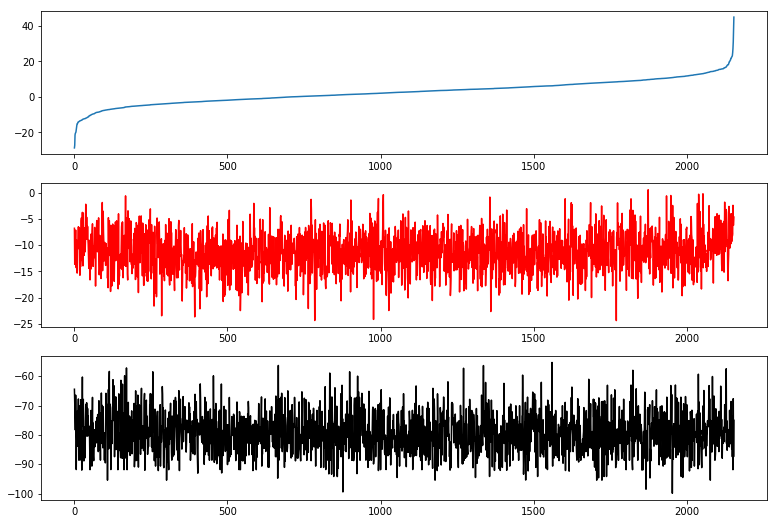

In [207]:
qmean_march, corr_march, qcorr_march = sort_vars(marchh)

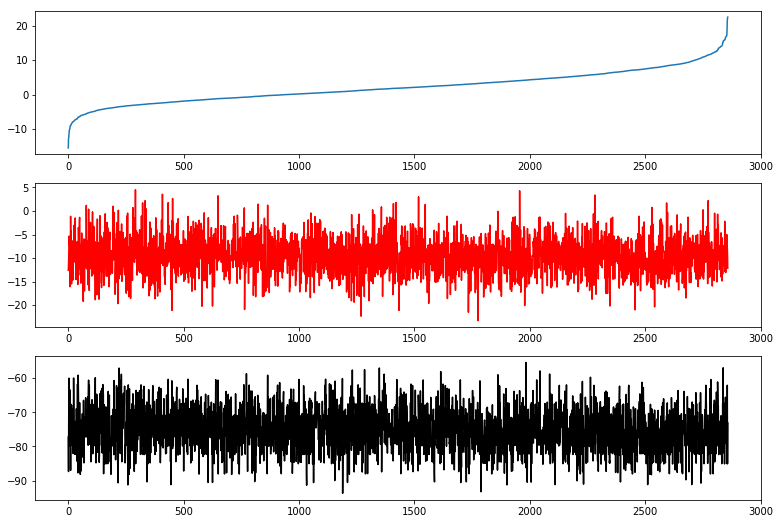

In [208]:
qmean_oct, corr_oct, qcorr_oct = sort_vars(octt)

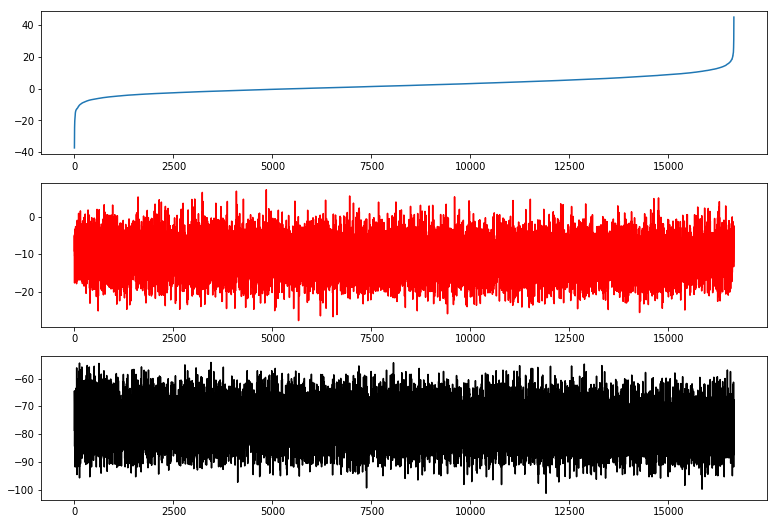

In [209]:
qmean_all, corr_all, qcorr_all = sort_vars(era_new)

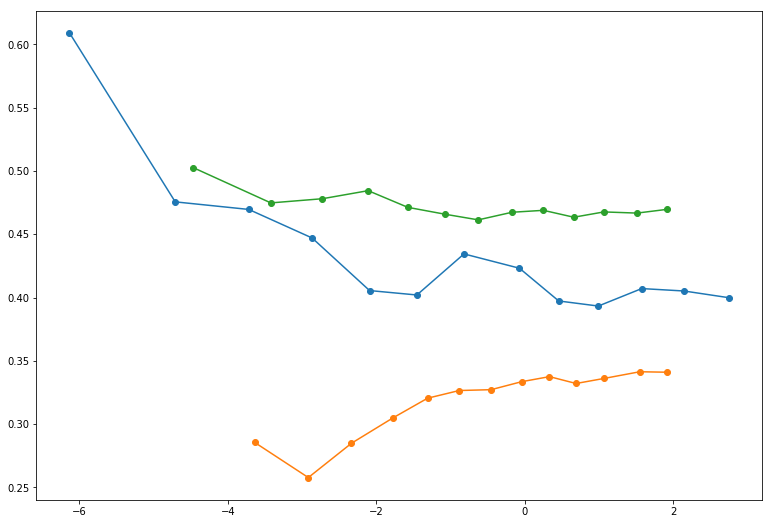

In [210]:
plt.figure(figsize=(13,9))
plt.plot(np.array(qmean_march),corr_march, '-o')
plt.plot(np.array(qmean_oct),corr_oct, '-o')
plt.plot(np.array(qmean_all),corr_all, '-o')